# MNIST - novelty detection scenario generation

For the problem of novelty detection we define two sets:
* _I_ = inlier set
* _O_ = outlier set

At training time, the model is presented with a _Training_ dataset so that the label of each sample belongs to _I_. The _Validation_ dataset is constructed to that the label of each sample belongs to _I_ and $Train \cap Validation = \varnothing$. The _Test_ set will contain both samples with labels belonging to _I_ as well as samples with labels belonging to _O_.

* $ Training = \{ (x, y) | y \in I \} $
* $ Validation = \{ (x, y) | y \in I \land x \not\in Training \} $
* $ Test = \{ (x, y) | y \in I \cup O \land x \not\in Training \cup Validation \} $


## Define datasets percentages

>NOTE: This is a generalization. If the dataset contains already a `test` split, then the _outlier_ samples will come only from this set.

* _Train_: $ 0.6 \times I $
* _Validation_: $ 0.2 \times I $
* _Test_: $ 0.2 \times I + 0.2 \times O $


## Scenario description

Five scenarios with increasing complexity are generated. The scenarios are constructed to simulate novel classes detection over time, as well as clustering of the novel classes. For each scenario we train a new model with the Train / Validation / Test sets as described above.  The _Inlier/Outlier_ class membership is described below. 

Scenario | Inlier Set (_I_) | Outlier Set (_O_)
---|---|---
1 | {1} | {0} 
2 | {0, 1} | {2, 3} 
3 | {0, 1, 2, 3} | {4, 5, 6} 
4 | {0, 1, 2, 3, 4, 5, 6} | {7, 8} 
5 | {0, 1, 2, 3, 4, 5, 6, 7, 8} | {9} 


## Evaluation

For each scenario, the accuracy of outliers detection is measured, and clustering is performed to recover the unknown outlier classes. The clustering membership performance is also measured (_i.e._ the percentage of samples with the same label that are correctly identified to belong to the same cluster).


In [54]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [55]:
DATA_DIR = Path("/Users/ccaloian/Temp/dl-pytorch/data/MNIST/numpy")
OUT_DIR = Path("/Users/ccaloian/Temp/dl-pytorch/data/MNIST/novelty-detection")

## Download MNIST dataset

The MNIST dataset was downloaded using the following code:

```bash
aws s3 sync \
    s3://sagemaker-sample-data-eu-west-1/tensorflow/mnist \
    /Users/ccaloian/Temp/dl-pytorch/data/MNIST/numpy
```

In [36]:
scenarios = {
    "1": {
        "inlier_classes": [1],
        "outlier_classes": [0],
        "prefix": "scenario-1"
    },
    "2": {
        "inlier_classes": [0, 1],
        "outlier_classes": [2, 3],
        "prefix": "scenario-2"
    },
    "3": {
        "inlier_classes": [0, 1, 2, 3],
        "outlier_classes": [4, 5, 6],
        "prefix": "scenario-3"
    },
    "4": {
        "inlier_classes": [0, 1, 2, 3, 4, 5, 6],
        "outlier_classes": [7, 8],
        "prefix": "scenario-4"
    },
    "5": {
        "inlier_classes": [0, 1, 2, 3, 4, 5, 6, 7, 8],
        "outlier_classes": [9],
        "prefix": "scenario-5"
    },
}

In [57]:
def make_mnist_novelty_detection_scenario(
    inlier_classes: list, 
    outlier_classes: list, 
    prefix: str,
    p : float = 0.7) -> tuple:
    """Create train/val/test sets for MNIST novelty detection scenarios.
    
    Train and Validation sets are created from p/(1-p) split of all the 
    `inlier_classes` in the MNIST `train` set. 
    
    Test set contains all `inlier_classess` and `outlier_classes` from 
    the MNIST `eval` set.
    """
    assert not np.any(np.isin(inlier_classes, outlier_classes)), \
        "Inlier and Outlier classes are overlapping!"
    
    eval_data = np.load(DATA_DIR / "eval_data.npy")
    eval_labels = np.load(DATA_DIR / "eval_labels.npy")
    train_data = np.load(DATA_DIR / "train_data.npy")
    train_labels = np.load(DATA_DIR / "train_labels.npy")
    
    train_data_chunks = []
    train_labels_chunks = []
    validation_data_chunks = []
    validation_labels_chunks = []
    
    # accumulate train and validation sets (data + labels)
    for ic in inlier_classes:
        ic_ix = np.argwhere(train_labels == ic).flatten()
        np.random.shuffle(ic_ix)
        n = len(ic_ix)
        train_ix, validation_ix = ic_ix[:int(n*p)], ic_ix[int(n*p):]
        train_data_chunks.append(train_data[train_ix])
        train_labels_chunks.append(train_labels[train_ix])
        validation_data_chunks.append(train_data[validation_ix])
        validation_labels_chunks.append(train_labels[validation_ix])
        
    train_X = np.vstack(train_data_chunks).reshape(-1, 28, 28, 1)
    train_y = np.hstack(train_labels_chunks).reshape(-1, 1)
    val_X = np.vstack(validation_data_chunks).reshape(-1, 28, 28, 1)
    val_y = np.hstack(validation_labels_chunks).reshape(-1, 1)
    
    # create test set
    c_ix = np.argwhere(np.isin(eval_labels, inlier_classes + outlier_classes)).flatten()
    test_X = eval_data[c_ix].reshape(-1, 28, 28, 1)
    test_y = eval_labels[c_ix].reshape(-1, 1)
    
    # make sure the directory exists
    (OUT_DIR / prefix).mkdir(parents=True, exist_ok=True)
        
    # write data to files
    np.save(OUT_DIR / prefix / "train_data.npy", train_X)
    np.save(OUT_DIR / prefix / "train_labels.npy", train_y)
    np.save(OUT_DIR / prefix / "validation_data.npy", val_X)
    np.save(OUT_DIR / prefix / "validation_labels.npy", val_y)
    np.save(OUT_DIR / prefix / "test_data.npy", test_X)
    np.save(OUT_DIR / prefix / "test_labels.npy", test_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [58]:
def load_mnist_scenario(prefix: str) -> tuple:
    """Load scenario data."""
    train_X = np.load(OUT_DIR / prefix / "train_data.npy")
    train_y = np.load(OUT_DIR / prefix / "train_labels.npy")
    val_X = np.load(OUT_DIR / prefix / "validation_data.npy")
    val_y = np.load(OUT_DIR / prefix / "validation_labels.npy")
    test_X = np.load(OUT_DIR / prefix / "test_data.npy")
    test_y = np.load(OUT_DIR / prefix / "test_labels.npy")

    return train_X, train_y, val_X, val_y, test_X, test_y

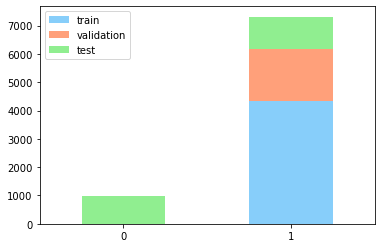

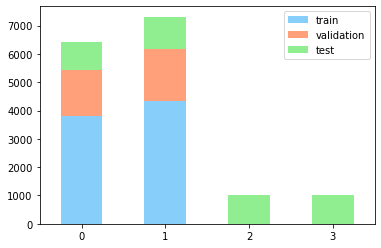

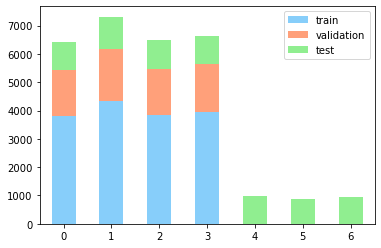

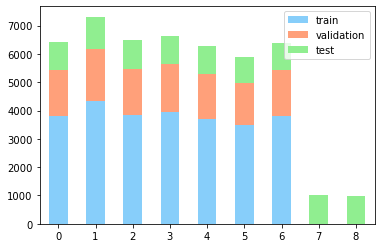

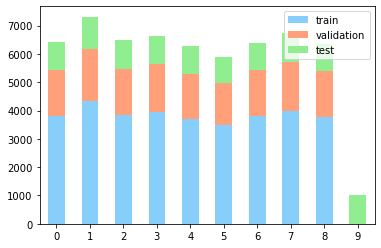

In [132]:
for i, params in scenarios.items():
    train_X, train_y, val_X, val_y, test_X, test_y = \
        make_mnist_novelty_detection_scenario(**params)
    # save a figure with the dataset distribution
    train_y_s = pd.Series(train_y.reshape(-1)).value_counts().sort_index()
    val_y_s = pd.Series(val_y.reshape(-1)).value_counts().sort_index()
    test_y_s = pd.Series(test_y.reshape(-1)).value_counts().sort_index()
    df = pd.DataFrame({"train": train_y_s, "validation": val_y_s, "test": test_y_s})
    fig = df.plot.bar(
        stacked=True, 
        rot=0, 
        color={"train": "lightskyblue", "validation": "lightsalmon", "test": "lightgreen"}
    ).get_figure();
    fig.savefig(OUT_DIR / f"scenario-{i}" / "dataset_distribution.png")

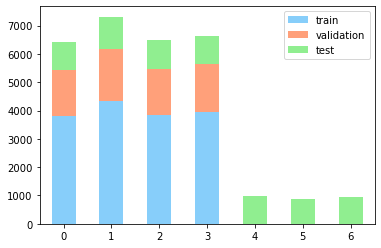

In [131]:
train_X, train_y, val_X, val_y, test_X, test_y = load_mnist_scenario("scenario-3")

train_y_s = pd.Series(train_y.reshape(-1)).value_counts().sort_index()
val_y_s = pd.Series(val_y.reshape(-1)).value_counts().sort_index()
test_y_s = pd.Series(test_y.reshape(-1)).value_counts().sort_index()
df = pd.DataFrame({"train": train_y_s, "validation": val_y_s, "test": test_y_s})

fig = df.plot.bar(
    stacked=True, 
    rot=0,
    color={"train": "lightskyblue", "validation": "lightsalmon", "test": "lightgreen"}
).get_figure();

In [133]:
print(f"Train data: {train_X.shape}")
print(f"Train labels: {train_y.shape}")
print(f"Validation data: {val_X.shape}")
print(f"Validation labels: {val_y.shape}")
print(f"Test data: {test_X.shape}")
print(f"Test labels: {test_y.shape}")

Train data: (34676, 28, 28, 1)
Train labels: (34676, 1)
Validation data: (14870, 28, 28, 1)
Validation labels: (14870, 1)
Test data: (10000, 28, 28, 1)
Test labels: (10000, 1)


## Upload data to S3

The generated scenarios are uploaded to S3 by running:

```bash
aws s3 sync \
    /Users/ccaloian/Temp/dl-pytorch/data/MNIST/novelty-detection \
    s3://novelty-detection-gan-grad
```

## Define PyTorch `Dataset` object

Define `Dataset` object for scenario data to be consumed by models.

In [134]:
class ScenarioDatasetMNIST(Dataset):
    """Novelty detection scenario dataset for MNIST."""
    
    def __init__(self, root_dir, partition, scenario, transform=None):
        self.root_dir = root_dir
        self.partition = partition
        self.scenario = scenario
        self.transform = transform
        self.data = np.load(f"{root_dir}/scenario-{scenario}/{partition}_data.npy")
        self.labels = np.load(f"{root_dir}/scenario-{scenario}/{partition}_labels.npy")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        
        sample = {"images": self.data[idx], "labels": self.labels[idx]}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
        
        
class ToTensor(object):
    """Convert data sample (data and labels) to PyTorch tensors."""
    
    def __call__(self, sample):
        image, label = sample["images"], sample["labels"]
        
        # swap color channel axes to `channels first`
        image = image.transpose((2, 0, 1))
        return {"images": torch.from_numpy(image),
                "labels": torch.from_numpy(label)}

## Test `Dataset` object

Load a scenario dataset with `DataLoader` and visualize a sampled batch.

In [135]:
ROOT_DIR = "/Users/ccaloian/Temp/dl-pytorch/data/MNIST/novelty-detection"

val_set = ScenarioDatasetMNIST(
    root_dir=ROOT_DIR,
    partition="validation",
    scenario="3",
    transform=ToTensor(),
)

for i in range(len(val_set)):
    sample = val_set[i]
    print(i, sample["images"].size(), sample["labels"].size())
    if i == 3:
        break

0 torch.Size([1, 28, 28]) torch.Size([1])
1 torch.Size([1, 28, 28]) torch.Size([1])
2 torch.Size([1, 28, 28]) torch.Size([1])
3 torch.Size([1, 28, 28]) torch.Size([1])


3 torch.Size([16, 1, 28, 28]) torch.Size([16, 1])
Batch labels: [2, 3, 3, 2, 2, 1, 2, 3, 3, 1, 1, 0, 2, 1, 3, 1]


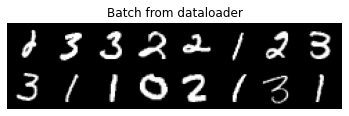

In [136]:
valsetloader = DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)

# Helper function to show a batch
def show_MNIST_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched["images"], sample_batched["labels"]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch, nrow=8)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title("Batch from dataloader")
        
for i_batch, sample_batched in enumerate(valsetloader):
    # observe 4th batch and stop.
    if i_batch == 3:
        print(i_batch, sample_batched["images"].size(), sample_batched["labels"].size())
        print("Batch labels: ", end="")
        print([sample_batched["labels"][i, 0].item() for i in range(sample_batched["labels"].size(0))])
        plt.figure()
        show_MNIST_batch(sample_batched)
        plt.axis("off")
        plt.show()
        break